In [1]:
from itertools import permutations
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from typing import Callable
# URL to make requests: fill in x and y coordinates
URL = 'http://65.108.84.176:22001/{}/{}'
NAME = 'final_task_tier_2'

# Final Task API #2

## 22001

### Solve the polinomial environment.

Objectives:
 1. Grid sample the environment.
 2. Fit the linear regression model.
 3. Fit the SVM model.
 4. Make moves in the environment.

In [2]:
# Collected points from the server with explorations spent
XY_EXPLORED = []
POINTS_EXPLORED = []
Z_MIN = None
# Initial agent coordinates
START_X = 0
START_Y = 0
# Path traversed by the agent
PATH = []
SOLVED = False

Useful reusable methods

In [3]:
def make_api_call(x: float=0.0, y: float=0.0) -> float:
    """Make an API call to the testing/exam server."""
    # Plug in x- and y-coordinates to gain the z-value of the point
    if (x, y) not in XY_EXPLORED and not SOLVED:
        response = requests.get(URL.format(x, y))
        z = response.json()['z']
        if Z_MIN and z < Z_MIN:
            z = Z_MIN
        XY_EXPLORED.append((x, y))
        POINTS_EXPLORED.append((x, y, z))
        return z
    # Reuse the known value
    return [_z for _x, _y, _z in POINTS_EXPLORED if _x == x and _y == y][0]

def get_grid_points(depth: int, step: float, include_zeros=False) -> tuple[np.ndarray, np.ndarray]:
    """Query a rectangular map representation of the environment."""
    _df = pd.DataFrame(POINTS_EXPLORED, columns=['x', 'y', 'z'])
    # Iterate over rows and columns
    for y in reversed(range(-depth, depth + 1)):
        for x in range(-depth, depth + 1):
            if x==0 and y==0 and not include_zeros:
                continue
            if _df[(_df['x'] == x) & (_df['y'] == y)].empty:
                if len(POINTS_EXPLORED) < 198:
                    make_api_call(x * step, y * step)
    # Return points in the numpy format
    grid_arr = np.array(POINTS_EXPLORED)
    return grid_arr[:, :2], grid_arr[:, 2]

def solve_environment(pred_model: Callable, _depth=100, _sort=True) -> list[tuple[int, int, float]]:
    """Predict z-values over all in-scope points using custom model."""
    all_points = []
    # Applies the model prediction over all cells in 201x201 grid from -100 to +100
    for _y in reversed(range(-_depth, _depth + 1)):
        for _x in range(-_depth, _depth + 1):
            _z = pred_model(_x, _y)
            all_points.append((_x, _y, _z))
    # Sort the list of points by z-values ascending
    if _sort:
        all_points = sorted(all_points, key=lambda x: x[2])
    return all_points

def calculate_euclidean_distance(p1, p2):
    """Find the distance between two points."""
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def find_hamiltonian_path(points):
    """Find the hamiltonian path between the richest points."""
    n = len(points)
    min_distance = float('inf')
    min_path = None
    for perm in permutations(points):
        total_distance = 0
        for i in range(n - 1):
            total_distance += calculate_euclidean_distance(perm[i], perm[i + 1])
        if total_distance < min_distance:
            min_distance = total_distance
            min_path = perm
    return min_path

def is_linear(_model, _xy, _z, threshold_r2=0.8, threshold_mse=10) -> bool:
    """Prove that the dataset relationship is linear."""
    z_pred = _model.predict(_xy)
    # Calculate R-squared
    r2 = r2_score(_z, z_pred)
    # Calculate Mean Squared Error
    mse = mean_squared_error(_z, z_pred)
    # Check if R-squared is above the threshold and MSE is below the threshold
    if r2 >= threshold_r2 and mse <= threshold_mse:
        return True
    else:
        return False

def is_pred_success(xy_points, test_model, _name: str='') -> tuple[bool, pd.DataFrame]:
    """Test if the model predicted path properly."""
    # Create a DataFrame
    _df = pd.DataFrame(xy_points, columns = ['x', 'y'])
    # Add experimental and theoretical values
    _df['z'] = _df.apply(lambda row: make_api_call(row['x'], row['y']), axis=1)
    _df['z_theory'] = _df.apply(lambda row: test_model(row['x'], row['y']), axis=1)
    # Save path
    if _name:
        _df[['x', 'y']].to_csv(f'{NAME}_{_name}.csv', index=False, header=False)
    # Find z-value sums
    z_experiment_sum = float(_df['z'].sum())
    z_theory_sum = float(_df['z_theory'].sum())
    relative_z_diff = abs(abs(z_theory_sum - z_experiment_sum) / z_theory_sum)
    print(f"Sum of all z-values traversed is {z_experiment_sum:.2f} (expected={z_theory_sum:.2f}; diff={relative_z_diff:.2f})")
    # Decide if predictions were successful; margin of error is 20%
    if relative_z_diff > 0.20:
        return False, _df
    return True, _df

def generate_random_points(num_points: int = 10, _depth=10):
    """Generate a random set of points in the close range to zero-coords."""
    res = []
    for _ in range(num_points):
        x = random.randint(-_depth, _depth)
        y = random.randint(-_depth, _depth)
        res.append((x, y))
    return res

#### 1. Grid sample the environment
Strategy:
1. Spend 25 explorations into getting 5x5 map representation of the environment.
2. If the relationship is linear, then the environment is deterministic.
3. Otherwise, the gridline would suggest where to look for the target.

In [4]:
xy, z = get_grid_points(4, 25, include_zeros=True)

#### 2. Fit a linear regression model

In [5]:
# Create a linear regression model and fit it to the grid sample
model = LinearRegression()
model.fit(xy, z)
# The coefficients and intercept of the plane
a, b = model.coef_
c = model.intercept_
# Prove linearity of the environment
is_linear_success = False
if is_linear(model, xy, z):
    # Replicate the function on the server
    linear_function = lambda x, y: a * x + b * y + c
    print(f"The linear function is: z(x, y) = {a:.2f}x + {b:.2f}y + {c:.2f}")
    # Find all coordinates in the deterministic environment
    all_points_sorted = solve_environment(linear_function)
    # Select top 10 values
    PATH = all_points_sorted[-10:]
    # Make the list of points
    incorrect_path = [(x, y) for x, y, _ in PATH]
    # Find the most optimal path between points
    hamiltonian_path = find_hamiltonian_path(incorrect_path)
    # Predict over the path
    is_linear_success, _ = is_pred_success(hamiltonian_path, linear_function, _name='linear')
# Show if linear regression was a good fit
if is_linear_success:
    SOLVED = True
    print("The environment is linear; therefore, deterministic and solved!")
else:
    print("The environment is not linear...")

The environment is not linear...


#### 3. Fit a support vector machine with RBF kernel

In [6]:
len(POINTS_EXPLORED)

81

In [7]:
is_rbf_success = False
# Small sample very close to the centre
_, _ = get_grid_points(5, 1, include_zeros=False)
# Medium sample near the centre
_, _ = get_grid_points(2, 35, include_zeros=False)
#
Z_MIN = -(sorted(POINTS_EXPLORED, key=lambda x: x[2])[-1][2])
POINTS_EXPLORED = [(x, y, z) if z > Z_MIN else (x, y, Z_MIN) for x, y, z in POINTS_EXPLORED]
# Transform data for ML
scaler = MinMaxScaler(feature_range=(0, 1))
# Tune hyperparameters
depths = [100]
c_values = [50, 70, 100, 200]
gamma_values = [100, 1000, 8_000, 12_000]
best_rmse = float('inf')
best_C = None
best_gamma = None
best_depth = None
# Also, iterate depth
for depth in depths:
    # Adjust depth
    xyz = np.array(POINTS_EXPLORED)
    x_values = xyz[:, 0]
    y_values = xyz[:, 1]
    xyz_select = xyz[(x_values < depth) & (y_values < depth)]
    # Select subsets
    xy = xyz_select[:, :2]
    z = xyz_select[:, 2]
    # Re-scale
    xy_scaled = scaler.fit_transform(xy)
    for c in c_values:
        for gamma in gamma_values:
            # Create SVR model with current C and gamma
            svr_model = SVR(kernel='rbf', C=c, gamma=gamma)
            # Compute cross-validated MSE using 5-fold cross-validation
            mse_scores = -cross_val_score(svr_model, xy_scaled, z, scoring='neg_mean_squared_error', cv=5)
            rmse = np.sqrt(np.mean(mse_scores))
            # Check if current combination yields lower MSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_C = c
                best_gamma = gamma
                best_depth = math.ceil(depth)
print("Best C:", best_C)
print("Best depth:", best_depth)
print("Best gamma:", best_gamma)
# Re-train the model with best hyperparameters
xyz = np.array(POINTS_EXPLORED)
x_values = xyz[:, 0]
y_values = xyz[:, 1]
xyz_select = xyz[(x_values < best_depth) & (y_values < best_depth)]
xy = xyz_select[:, :2]
z = xyz_select[:, 2]
xy_scaled = scaler.fit_transform(xy)
# Use best C and gamma
rbf_svm_model = SVR(kernel='rbf', degree=4, C=best_C, gamma=best_gamma)
rbf_svm_model.fit(xy_scaled, z)
# Wrap the model into a simple x,y -> z function
def rbf_svm_model_wrapper(_x: float=0.0, _y: float=0.0) -> float:
    """Wraps scikit-learn model."""
    scaled_xy = scaler.transform(np.array([[_x, _y]]))
    return rbf_svm_model.predict(scaled_xy)[0]
# Find all coordinates in the deterministic environment
all_points_sorted = solve_environment(rbf_svm_model_wrapper, _depth=best_depth)
# Select top 50 values
TOP_TILE = all_points_sorted[-1]
POINT_DICT = {(x, y): z for x, y, z in all_points_sorted}
PATH = []
def build_path(curr_x, curr_y, pick_second: bool=False):
    """Build path."""
    if len(PATH) >= 10:
        return
    options = []
    for next_x in range(curr_x-1, curr_x+2):
        for next_y in range(curr_y-1, curr_y+2):
            if (next_x, next_y) not in PATH and abs(next_x) <= best_depth and abs(next_y) <= best_depth:
                options.append((next_x, next_y, POINT_DICT[(next_x, next_y)]))
    # Pick max
    if options and pick_second:
        best_option = sorted(options, key=lambda x: x[2])[-2]
        PATH.append(best_option)
        return build_path(best_option[0], best_option[1])
    elif options:
        best_option = sorted(options, key=lambda x: x[2])[-1]
        PATH.append((best_option[0], best_option[1]))
        return build_path(best_option[0], best_option[1])
    else:
        _ = PATH.pop
        return build_path(curr_x, curr_y, pick_second=True)
build_path(TOP_TILE[0], TOP_TILE[1])
# Predict over the path
is_rbf_success, df = is_pred_success(PATH, rbf_svm_model_wrapper, _name='rbf')
# Show the good fit
if is_rbf_success:
    print(f"The environment has been well-learned using RBF kernel (gamma={best_gamma}); therefore, an environment is somewhat predictable!")
else:
    print(f"The environment was not estimated using RBF kernel (gamma={best_gamma})...")

Best C: 50
Best depth: 100
Best gamma: 12000
Sum of all z-values traversed is 32333.00 (expected=31445.32; diff=0.03)
The environment has been well-learned using RBF kernel (gamma=12000); therefore, an environment is somewhat predictable!


### How many points explored + traversed?

In [8]:
len(POINTS_EXPLORED)

201

### Visual representation

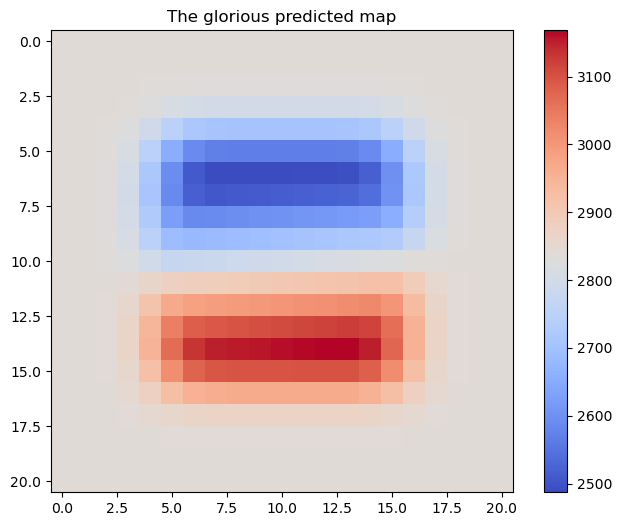

In [9]:
def get_square_map(funci: Callable, depth: int = 2, step: float = 1, name = 'test') -> np.ndarray:
    """Query a rectangular map representation of the environment."""
    size = 2 * depth + 1
    square_map = np.zeros((size, size))
    # Iterate over rows and columns
    for y in reversed(range(-depth, depth + 1)):
        for x in range(-depth, depth + 1):
            square_map[-y + depth, x + depth] = funci(x * step, y * step)
    # Save the map as a text file
    np.savetxt(f'{name}_map.txt', square_map, fmt='%d')
    return square_map

def plot_heatmap(square_map: np.ndarray, name = 'test') -> None:
    """Plot the squared environment as a heatmap."""
    # Find min-max values to set up temperature properly
    min_val = np.min(square_map)
    max_val = np.max(square_map)
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(square_map, cmap='coolwarm', vmin=min_val, vmax=max_val, interpolation='nearest')
    plt.title(f'The glorious {name} map')
    plt.colorbar()
    plt.show()
# Test
plot_heatmap(get_square_map(rbf_svm_model_wrapper, depth=int(10), name='predicted'), name='predicted')

In [10]:
Z_MIN

-23300

In [11]:
all_points_sorted[-1]

(3, -4, 3168.428277073765)